# Simulation

In [1]:
import pickle
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
import uuid
from pandarallel import pandarallel
from tqdm.notebook import tqdm
from copy import deepcopy

pandarallel.initialize()

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### Read position data

In [2]:
data = []
fnames = glob.glob("position/*.dat")
for fname in fnames:
    X = pickle.load(open(fname, "rb"))
    data.append(X)

In [3]:
bound_max = 800
bound_min = -800

### Define pattern's probability

In [4]:
p = [.32, .25, .17, .14, .09, .03]

In [5]:
np.random.choice(range(len(data)), p=p)

2

### Visualize patterns

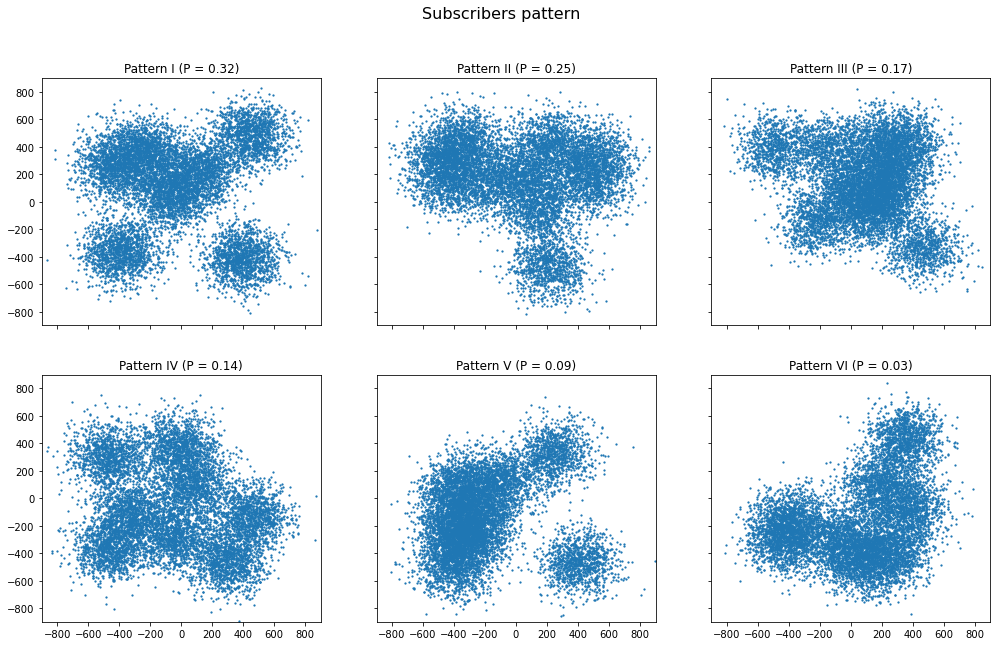

In [6]:
fig, axs = plt.subplots(2,3, figsize=(17,10), sharex=True, sharey=True)
fig.suptitle('Subscribers pattern', fontsize=16)
plt.xlim(-900, 900)
plt.ylim(-900, 900)

axs[0][0].scatter(data[0][:,0], data[0][:,1], s=1.5)
axs[0][0].set_title("Pattern I (P = 0.32)")

axs[0][1].scatter(data[1][:,0], data[1][:,1], s=1.5)
axs[0][1].set_title("Pattern II (P = 0.25)")

axs[0][2].scatter(data[2][:,0], data[2][:,1], s=1.5)
axs[0][2].set_title("Pattern III (P = 0.17)")

axs[1][0].scatter(data[3][:,0], data[3][:,1], s=1.5)
axs[1][0].set_title("Pattern IV (P = 0.14)")

axs[1][1].scatter(data[4][:,0], data[4][:,1], s=1.5)
axs[1][1].set_title("Pattern V (P = 0.09)")

axs[1][2].scatter(data[5][:,0], data[5][:,1], s=1.5)
axs[1][2].set_title("Pattern VI (P = 0.03)")

plt.show()

### Distance function  
#### Euclidean distance with 1:12 scale

In [7]:
def distance_scale(p1, p2, scale=1):
    return (((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**(1/2)) * scale

### Signal strength function  
Assume no obstacles:  
$FSPL_{dB} = 20log_{10}d + 20log_{10}f + 32.44$  
For $d$ in meters and $f$ in megahertz  

In [8]:
def fspl(d, f):
    return - ((20*np.log10(d)) + (20*np.log10(f)) - 32.44)

### Stations

In [9]:
types = ["900 MHz Type I", "900 MHz Type II", "1800 MHz Type I", "1800 MHz Type II", "2600 MHz Type I", "2600 MHz Type II"]
frequency = [900, 900, 1800, 1800, 2600, 2600]
capacity = [800, 1200, 850, 1250, 800 ,1300]
cost = [1150000, 1500000, 880000, 1220000, 950000, 1350000]
station_types = pd.DataFrame({"types": types, "frequency":frequency, "capacity":capacity, "cost":cost})

In [10]:
station_types

,types,frequency,capacity,cost
0,900 MHz Type I,900,800,1150000
1,900 MHz Type II,900,1200,1500000
2,1800 MHz Type I,1800,850,880000
3,1800 MHz Type II,1800,1250,1220000
4,2600 MHz Type I,2600,800,950000
5,2600 MHz Type II,2600,1300,1350000


In [11]:
station_max = 20

In [12]:
class Station(object):
    def __init__(self, s_type, x, y, frequency, capacity, cost):
        self.id = str(uuid.uuid4())
        self.type = s_type
        self.x = x
        self.y = y
        self.frequency = frequency
        self.capacity = capacity
        self.current_capacity = 0
        self.cost = cost
    
    def is_full(self):
        return True if self.current_capacity >= self.capacity else False
    
    def new_subscriber(self):
        if not self.is_full():
            self.current_capacity += 1
    
    def __str__(self):
        return f"""\rStation
        \r\tName: {self.id}
        \r\tType: {self.type}
        \r\tPosition: ({self.x}, {self.y})
        \r\tFrequency: {self.frequency}
        \r\tCapacity: {self.current_capacity}/{self.capacity}
        \r\tCost: {self.cost}
        """

In [14]:
s_info = station_types.sample(n=1).iloc[0]
s = Station(s_info["types"], 100, 100, s_info["frequency"], s_info["capacity"], s_info["cost"])
print(s)

Station
	Name: 6888acef-480a-47bb-98e9-fa4f5826a3af
	Type: 2600 MHz Type I
	Position: (100, 100)
	Frequency: 2600
	Capacity: 0/800
	Cost: 950000
        


### Solution class and helper function

In [15]:
def stations_crossover(s1, s2):
    pos1 = np.random.randint(len(s1)-1) if len(s1) > 1 else 0
    pos2 = np.random.randint(len(s2)-1) if len(s2) > 1 else 0
    s_result = deepcopy(s1)
    s_result[pos1] = s2[pos2]
    return s_result

def stations_mutation(s):
    mutation_pos = np.random.randint(len(s)-1)  if len(s) > 1 else 0
    s_result = deepcopy(s)
    s_info = station_types.sample(n=1).iloc[0]
    pos = np.random.uniform(bound_min, bound_max, 2)
    s = Station(s_info["types"], pos[0], pos[1], s_info["frequency"], s_info["capacity"], s_info["cost"])
    s_result[mutation_pos] = s
    return s_result

def assign_new_station(solution, stations):
    solution_local = deepcopy(solution)
    solution_local.stations = deepcopy(stations)
    solution_local.reset()
    return solution_local    

In [57]:
class Solution(object):
    def __init__(self, stations):
        self.id = str(uuid.uuid4())
        self.stations = deepcopy(stations)
        self.is_compute = False
        self.signal_strength_l = []
        self.num_orphans = 0
        self.signal_strength = np.nan
        self.construction_cost = np.nan
        self.fitness = np.nan
        
    def compute_infos(self, position):
        for sb in position:
            signal_strength = []
            for idx, st in enumerate(self.stations):
                if not st.is_full():
                        d = distance_scale((sb[0], sb[1]), (st.x, st.y), scale=12)
                        p = fspl(d, st.frequency)
                        signal_strength.append((idx, p))
            if signal_strength:        
                signal_strength.sort(key=lambda x:x[1], reverse=True)
                self.stations[signal_strength[0][0]].new_subscriber()
                self.signal_strength_l.append(signal_strength[0][1])
            else:
                self.num_orphans += 1
                self.signal_strength_l.append(np.nan)

        self.signal_strength = np.nanmean(self.signal_strength_l)
        self.construction_cost = sum([x.cost for x in self.stations])
        self.fitness = -(self.signal_strength/110) + (self.construction_cost/40000000) + (self.num_orphans/1000)
        self.is_compute = True
        return self
    
    def reset(self):
        self.id = str(uuid.uuid4())
        self.is_compute = False
        self.signal_strength_l = []
        self.num_orphans = 0
        self.signal_strength = np.nan
        self.construction_cost = np.nan
        self.fitness = np.nan
        for s in self.stations:
            s.id = str(uuid.uuid4())
            s.current_capacity = 0
    
    def __str__(self):
        ret = f"""Solution : {self.id}\n\tComputed?: {self.is_compute}\n\tFitness value: {self.fitness}\n\tAverage signal stength: {self.signal_strength}\n\tOrphans: {self.num_orphans}\n\tConstruction cost: {self.construction_cost}"""
        return ret

### Simulation parameters

In [86]:
n_population = 500
crossover_p = 0.2
mutation_p = 0.01
elitism_ratio = 0.75
trim_policy = "best"  # "random" or "best"
num_iters = 5
checkpoint_every = 20

### Initial population

In [87]:
def generate_station(n):
    stations = []
    for i in range(n):
        s_info = station_types.sample(n=1).iloc[0]
        pos = np.random.uniform(-800, 800, size=2)
        s = Station(s_info["types"], pos[0], pos[1], s_info["frequency"], s_info["capacity"], s_info["cost"])
        stations.append(s)
    return stations

In [88]:
stations_l = [generate_station(n) for n in np.random.randint(1,21, size=n_population)]

solution_pool = [Solution(stations_l[i]) for i in range(n_population)]

solution_df = pd.DataFrame({"solution_id":[x.id for x in solution_pool],
                            "solution_obj": solution_pool,
                            "from_generation":[-1]*n_population
                           })

### Iteration

In [89]:
def crossover(population, crossover_prop):
    population = deepcopy(population)
    crossover_df1 = population[["solution_obj"]].sample(frac=crossover_prop/2).reset_index(drop=True)
    crossover_df2 = population[["solution_obj"]].sample(frac=crossover_prop/2).reset_index(drop=True)
    crossover_df = pd.concat([crossover_df1, crossover_df2], axis=1)
    crossover_df.columns = ["solution_obj_x","solution_obj_y"]
    crossover_df["new_station"] = crossover_df.parallel_apply(lambda x:stations_crossover(x["solution_obj_x"].stations, x["solution_obj_y"].stations), axis=1)
    crossover_df["solution_obj_z"] = crossover_df.parallel_apply(lambda x:assign_new_station(x["solution_obj_x"], x["new_station"]), axis=1)
    crossover_df.drop(columns=["solution_obj_x", "solution_obj_y", "new_station"], inplace=True)
    crossover_df = crossover_df.rename(columns={"solution_obj_z":"solution_obj"})
    return crossover_df

def mutation(population, mutation_p):
    population = deepcopy(population)
    mutation_df = population[["solution_obj"]].sample(frac=mutation_p).reset_index(drop=True)
    mutation_df["new_station"] = mutation_df.parallel_apply(lambda x:stations_mutation(x["solution_obj"].stations), axis=1)
    mutation_df["solution_obj_z"] = mutation_df.parallel_apply(lambda x:assign_new_station(x["solution_obj"], x["new_station"]), axis=1)
    mutation_df.drop(columns=["solution_obj", "new_station"], inplace=True)
    mutation_df = mutation_df.rename(columns={"solution_obj_z":"solution_obj"})
    return mutation_df

def compute(population, position):
    population = deepcopy(population)
    population["solution_obj"] = population["solution_obj"].parallel_apply(lambda x:x.compute_infos(position))
    population["signal_strength"] = population["solution_obj"].parallel_apply(lambda x:x.signal_strength)
    population["construction_cost"] = population["solution_obj"].parallel_apply(lambda x:x.construction_cost)
    population["num_orphans"] = population["solution_obj"].parallel_apply(lambda x:x.num_orphans)
    population["fitness_value"] = population["solution_obj"].parallel_apply(lambda x:x.fitness)
    
    return population

In [90]:
best_of_iteration = []
for i in tqdm(range(num_iters)):
    print(f"Iteration {i+1}/{num_iters}")
    position = data[np.random.choice(range(len(data)), p=p)]
    print(f"\tComputing fitness value...")
    solution_df = compute(solution_df, position)
    solution_df = solution_df.sort_values(by="fitness_value")
    
    new_solution_df = pd.DataFrame()
    if crossover_p:
        print(f"\tCrossover...")
        crossover_df = crossover(solution_df, crossover_p)
        new_solution_df = pd.concat([new_solution_df, crossover_df])
    if mutation_p:
        print(f"\tMutation...")
        mutation_df = mutation(solution_df, mutation_p)
        new_solution_df = pd.concat([new_solution_df, mutation_df])
        
    if new_solution_df.shape[0] != 0:
        print(f"\tComputing fitness value of new solutions...")
        new_solution_df["solution_id"] = new_solution_df["solution_obj"].parallel_apply(lambda x:x.id)
        new_solution_df = compute(new_solution_df, position)
        new_solution_df["from_generation"] = [i]*new_solution_df.shape[0]
    
    print(f"\tTrimming result...")
    solution_df = pd.concat([solution_df, new_solution_df], ignore_index=True).sample(n=n_population).reset_index(drop=True)\
                    if trim_policy=="random" \
                    else \
                    pd.concat([solution_df, new_solution_df], ignore_index=True).sort_values(by="fitness_value").head(n_population).reset_index(drop=True)
    
    if elitism_ratio:
        print(f"\tPerforming elite selection and reinitialize...")
        n_elite = int(solution_df.shape[0] * elitism_ratio)
        n_reinit = solution_df.shape[0] - n_elite
        solution_df = solution_df.sort_values(by="fitness_value").head(n_elite)
        reinit_stations_l = [generate_station(n) for n in np.random.randint(1,21, size=n_reinit)]
        reinit_pool = [Solution(s) for s in reinit_stations_l]
        reinit_solution_df = pd.DataFrame({"solution_id":[x.id for x in reinit_pool],
                                          "solution_obj": reinit_pool
                                         })
        reinit_solution_df = compute(reinit_solution_df, position)
        reinit_solution_df["from_generation"] = [i]*reinit_solution_df.shape[0]
        solution_df = pd.concat([solution_df, reinit_solution_df], ignore_index=True)
    
    best = deepcopy(solution_df[solution_df['fitness_value']==min(solution_df['fitness_value'])])
    best_of_iteration.append(best)
    print(f"\tBest fitness of this iteration: {best['fitness_value'].iloc[0]}")
    if num_iters%checkpoint_every == 0:
        fname = f"solutions/solution-{i:04d}.pkl"
        print(f"\tSaving checkpint at {fname}")
        solution_df.to_pickle(fname)
    print(f"\tDone!")

  0%|          | 0/5 [00:00<?, ?it/s]

Iteration 1/5
	Computing fitness value...
	Crossover...
	Mutation...
	Computing fitness value of new solutions...
	Trimming result...
	Performing elite selection and reinitialize...
	Best fitness of this iteration: 1.206736307326664
	Done!
Iteration 2/5
	Computing fitness value...
	Crossover...
	Mutation...
	Computing fitness value of new solutions...
	Trimming result...
	Performing elite selection and reinitialize...
	Best fitness of this iteration: 1.204261774058928
	Done!
Iteration 3/5
	Computing fitness value...
	Crossover...
	Mutation...
	Computing fitness value of new solutions...
	Trimming result...
	Performing elite selection and reinitialize...
	Best fitness of this iteration: 1.2045969787398132
	Done!
Iteration 4/5
	Computing fitness value...
	Crossover...
	Mutation...
	Computing fitness value of new solutions...
	Trimming result...
	Performing elite selection and reinitialize...
	Best fitness of this iteration: 1.2006346635675886
	Done!
Iteration 5/5
	Computing fitness value

In [91]:
solution_df

,solution_id,solution_obj,from_generation,signal_strength,construction_cost,num_orphans,fitness_value
0,b0634764-11ce-4026-be84-38447a2f505c,Solution : b0634764-11ce-4026-be84-38447a2f505...,4,-98.548296,13190000,0,1.225644
1,8346aad3-a1de-4cbe-969e-6dd3ef2f70ab,Solution : 8346aad3-a1de-4cbe-969e-6dd3ef2f70a...,4,-100.533990,12810000,0,1.234195
2,a46634e4-7d4a-4529-9ffe-2eb4d0ace285,Solution : a46634e4-7d4a-4529-9ffe-2eb4d0ace28...,4,-101.932766,12480000,0,1.238662
3,82cd5626-b8d9-4e63-be39-021bab5a448a,Solution : 82cd5626-b8d9-4e63-be39-021bab5a448...,4,-104.022395,12190000,0,1.250408
4,ef9a4b14-2d76-43f6-b50d-f9026573f597,Solution : ef9a4b14-2d76-43f6-b50d-f9026573f59...,4,-104.211603,12670000,0,1.264128
...,...,...,...,...,...,...,...
495,abf4524f-d11f-45f9-ae85-1341b3f940e2,Solution : abf4524f-d11f-45f9-ae85-1341b3f940e...,4,-102.932457,15160000,0,1.314750
496,775510ba-c127-4366-8a3e-919304e5c4d5,Solution : 775510ba-c127-4366-8a3e-919304e5c4d...,4,-104.656324,11790000,0,1.246171
497,fd842ef3-f30a-4018-a591-1e3be20b7f49,Solution : fd842ef3-f30a-4018-a591-1e3be20b7f4...,4,-104.416905,6380000,4650,5.758745
498,2f5d1640-9124-4344-aba4-84c01b82f8a7,Solution : 2f5d1640-9124-4344-aba4-84c01b82f8a...,4,-104.890146,3330000,7150,8.186797


In [1133]:
solution_df.to_pickle("solutions/solution.pkl", compression="bz2")

In [1109]:
a = pd.DataFrame()

In [1112]:
if a.shape[0] != 0:
    print("True")

In [1091]:
position = data[np.random.choice(range(len(data)), p=p)]

In [1035]:
%%time
solution_df["solution_obj"] = solution_df["solution_obj"].parallel_apply(lambda x:x.compute_infos(position, return_self=True))
solution_df["signal_strength"] = solution_df["solution_obj"].parallel_apply(lambda x:x.signal_strength)
solution_df["construction_cost"] = solution_df["solution_obj"].parallel_apply(lambda x:x.construction_cost)
solution_df["num_orphans"] = solution_df["solution_obj"].parallel_apply(lambda x:x.num_orphans)
solution_df["fitness_value"] = solution_df["solution_obj"].parallel_apply(lambda x:x.fitness)

CPU times: user 24.5 s, sys: 1.24 s, total: 25.7 s
Wall time: 1min 5s


In [1036]:
solution_df.sort_values(by="fitness_value")

,solution_id,solution_obj,signal_strength,construction_cost,num_orphans,fitness_value
437,c019d543-c3cd-48ea-9219-2cb34dce0311,Solution : c019d543-c3cd-48ea-9219-2cb34dce031...,-100.370694,11480000,0,1.199461
361,244ea600-008b-4bc4-946b-e8cbb9404efb,Solution : 244ea600-008b-4bc4-946b-e8cbb9404ef...,-102.735692,11570000,0,1.223211
35,bc31fd5b-9e16-4316-b26c-bb1ba508ca4f,Solution : bc31fd5b-9e16-4316-b26c-bb1ba508ca4...,-103.322996,11980000,0,1.238800
453,4f9dcab9-f3b6-4287-b3e5-d79137c8e310,Solution : 4f9dcab9-f3b6-4287-b3e5-d79137c8e31...,-102.739148,12340000,0,1.242492
434,f780d829-763d-4afe-bfda-ec058e508200,Solution : f780d829-763d-4afe-bfda-ec058e50820...,-103.170563,12200000,0,1.242914
...,...,...,...,...,...,...
37,85166810-240c-467c-9e94-559ffd5caa3b,Solution : 85166810-240c-467c-9e94-559ffd5caa3...,-114.852037,950000,9200,10.267859
257,c0b50803-2d34-4a13-8e8d-2ac212c883d7,Solution : c0b50803-2d34-4a13-8e8d-2ac212c883d...,-114.935117,950000,9200,10.268615
29,6b96647f-c68b-4418-a060-5cb1cae8e0e6,Solution : 6b96647f-c68b-4418-a060-5cb1cae8e0e...,-115.559116,950000,9200,10.274287
313,3e8479b7-1ddd-4b7c-96da-3bf3c166fe05,Solution : 3e8479b7-1ddd-4b7c-96da-3bf3c166fe0...,-116.440274,950000,9200,10.282298


In [1038]:
crossover_df1 = solution_df[["solution_obj"]].sample(frac=crossover/2).reset_index(drop=True)
crossover_df2 = solution_df[["solution_obj"]].sample(frac=crossover/2).reset_index(drop=True)

In [1054]:
crossover_df = pd.concat([crossover_df1, crossover_df2], axis=1)
crossover_df.columns = ["solution_obj_x","solution_obj_y"]
crossover_df["new_station"] = crossover_df.apply(lambda x:stations_crossover(x["solution_obj_x"].stations, x["solution_obj_y"].stations), axis=1)
crossover_df["solution_obj_z"] = crossover_df.apply(lambda x:assign_new_station(x["solution_obj_x"], x["new_station"]), axis=1)
crossover_df.drop(columns=["solution_obj_x", "solution_obj_y", "new_station"], inplace=True)
crossover_df = crossover_df.rename(columns={"solution_obj_z":"solution_obj"})

In [1055]:
crossover_df.head()

,solution_obj
0,Solution : 361fcf87-07e2-4263-ae42-e338d7683b3...
1,Solution : 07177256-c140-4c55-83d4-9ca5bd836d8...
2,Solution : 1f737903-8392-46f4-879b-ee98f61d688...
3,Solution : 6b398d0e-d17b-4d81-a69a-bde4511e3eb...
4,Solution : c10ac6a7-bd0c-4574-bdce-fc4c05fb404...


In [1057]:
mutation_df = solution_df[["solution_obj"]].sample(frac=mutation).reset_index(drop=True)
mutation_df["new_station"] = mutation_df.apply(lambda x:stations_mutation(x["solution_obj"].stations), axis=1)
mutation_df["solution_obj_z"] = mutation_df.apply(lambda x:assign_new_station(x["solution_obj"], x["new_station"]), axis=1)

mutation_df.drop(columns=["solution_obj", "new_station"], inplace=True)
mutation_df = mutation_df.rename(columns={"solution_obj_z":"solution_obj"})

In [1058]:
mutation_df.head()

,solution_obj
0,Solution : 73030790-8c81-4f45-80a5-dde542fea82...
1,Solution : daafb0d8-daa7-4fdf-a59b-f151893c875...
2,Solution : 2a62524f-7103-47bf-a2dc-1a03409183a...
3,Solution : 851c8643-faaa-4145-9471-38a415d1100...
4,Solution : 3a445996-f485-4603-afe5-d1e9e316971...


In [1069]:
new_solution_df = pd.concat([crossover_df, mutation_df], ignore_index=True)

In [1070]:
%%time
new_solution_df["solution_id"] = new_solution_df["solution_obj"].parallel_apply(lambda x:x.id)
new_solution_df["solution_obj"] = new_solution_df["solution_obj"].parallel_apply(lambda x:x.compute_infos(position, return_self=True))
new_solution_df["signal_strength"] = new_solution_df["solution_obj"].parallel_apply(lambda x:x.signal_strength)
new_solution_df["construction_cost"] = new_solution_df["solution_obj"].parallel_apply(lambda x:x.construction_cost)
new_solution_df["num_orphans"] = new_solution_df["solution_obj"].parallel_apply(lambda x:x.num_orphans)
new_solution_df["fitness_value"] = new_solution_df["solution_obj"].parallel_apply(lambda x:x.fitness)

CPU times: user 2.38 s, sys: 762 ms, total: 3.14 s
Wall time: 8.48 s


In [1071]:
new_solution_df.head()

,solution_obj,solution_id,signal_strength,construction_cost,num_orphans,fitness_value
0,Solution : 361fcf87-07e2-4263-ae42-e338d7683b3...,361fcf87-07e2-4263-ae42-e338d7683b38,-100.908642,21490000,0,1.454601
1,Solution : 07177256-c140-4c55-83d4-9ca5bd836d8...,07177256-c140-4c55-83d4-9ca5bd836d8a,-111.603086,880000,9150,10.186574
2,Solution : 1f737903-8392-46f4-879b-ee98f61d688...,1f737903-8392-46f4-879b-ee98f61d6887,-99.798425,17980000,0,1.356758
3,Solution : 6b398d0e-d17b-4d81-a69a-bde4511e3eb...,6b398d0e-d17b-4d81-a69a-bde4511e3ebd,-99.923595,20680000,0,1.425396
4,Solution : c10ac6a7-bd0c-4574-bdce-fc4c05fb404...,c10ac6a7-bd0c-4574-bdce-fc4c05fb4046,-107.803206,7530000,3450,4.618279


In [1086]:
solution_df1 = pd.concat([solution_df, new_solution_df], ignore_index=True).sample(n=n_population).reset_index(drop=True) if trim_policy=="random" else pd.concat([solution_df, new_solution_df], ignore_index=True).sort_values(by="fitness_value").head(n_population).reset_index(drop=True)

In [1087]:
solution_df1

,solution_id,solution_obj,signal_strength,construction_cost,num_orphans,fitness_value
0,5701ac3d-820a-4beb-b58a-e1605efc671c,Solution : 5701ac3d-820a-4beb-b58a-e1605efc671...,-101.890054,13430000,0,1.262023
1,63fa5726-bfff-43a7-bc65-ef761231f622,Solution : 63fa5726-bfff-43a7-bc65-ef761231f62...,-104.087898,10970000,450,1.670504
2,df29db2c-fcef-4b3f-9424-1e3fa3e6ad70,Solution : df29db2c-fcef-4b3f-9424-1e3fa3e6ad7...,-105.480966,12280000,350,1.615918
3,099ecf40-12ac-45ce-96e3-cbe7dc104635,Solution : 099ecf40-12ac-45ce-96e3-cbe7dc10463...,-113.082490,2850000,7500,8.599273
4,7f179f17-f2df-46ba-b538-8142018684b3,Solution : 7f179f17-f2df-46ba-b538-8142018684b...,-96.209232,22080000,0,1.426629
...,...,...,...,...,...,...
495,165e5238-daa5-4ea8-87e8-2619a29df6db,Solution : 165e5238-daa5-4ea8-87e8-2619a29df6d...,-99.215255,24210000,0,1.507207
496,dee2a869-0e44-49ff-9767-e1423cb9870d,Solution : dee2a869-0e44-49ff-9767-e1423cb9870...,-97.758316,22500000,0,1.451212
497,ed912ea8-d1c1-4cd6-8c88-2f9ea6f7facc,Solution : ed912ea8-d1c1-4cd6-8c88-2f9ea6f7fac...,-108.469013,4880000,5450,6.558082
498,0497aba1-758a-4801-a2a0-84e43b2ed7f5,Solution : 0497aba1-758a-4801-a2a0-84e43b2ed7f...,-104.439066,7120000,3850,4.977446


---